## The U-Net model

The U-Net model has two main parts: the `contracting path` which is the left side of the model and the `expanding path` which is the right side of the model. The image below shows the U-Net architecture and how it contracts and then expands.
![image](https://drive.google.com/uc?export=view&id=1XgJRexE2CmsetRYyTLA7L8dsEwx7aQZY)

We can see that images are first fed through many convolutional layers which reduce height and width while increasing the channels, which the authors refer to as the **contracting path**. For example, a set of two 2 x 2 convolutions with a stride of 2, will take a 1 x 28 x 28 (channels, height, width) grayscale image and result in a 2 x 14 x 14 representation. The **expanding path** does the opposite, gradually growing the image with fewer and fewer channels.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from util2d import soft_dice_loss, dice_coefficient, unet_model_2d

#from tensorflow.keras import Input, Model
#from tensorflow.keras.layers import (
#    Activation, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Cropping2D, concatenate)
#from tensorflow.keras import backend as K

In [2]:
# you can use more real values here
BATCH_SIZE = 4
BUFFER_SIZE = 1000
EPOCHS = 1   # just checking the model

In [3]:
# First step is to load the dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True, data_dir="./data", download=True,
            download_and_prepare_kwargs={"download_dir": "./data"})

### The Contracting Path

This path is the encoder section of the U-Net, which has several downsampling steps as part of it. The authors give more detail of the remaining parts in the following paragraph from the paper (Renneberger, 2015):

>The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two 3 x 3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels.

The different arrows represent different layers and operations










![contract](images/contract.jpg)

<p>
    <bold><center>Contracting Path</center></bold>
</p>

<p>
    <img src="images/arrows.png" alt>
</p>
<p>
    <bold><center>Arrows label</center></bold>
</p>

The images are first fed through many convolutional layers which reduce height and width while increasing the channels, which the authors refer to as the `contracting path`. For example, a set of two 2 x 2 convolutions with a stride of 2, will take a 1 x 28 x 28 (channels, height, width) grayscale image and result in a 2 x 14 x 14 representation. The `expanding path` does the opposite, gradually growing the image with fewer and fewer channels.

So, consider in the Part-1 of the U-Net architecture, where 64 represents the filter size to be used in the convolutional layer and (572x572) (570x570)(568,568) represents the image size. Here the paper explains the output image size after each layer.
<p>
    <img src="images/part1.png" alt>
</p>
<p>
    <bold><center>Part - 1</center></bold>
</p>
Note that for each conv layer, we have a decrease of 2 in image size. Remember the deep learning class where when we have no padding, the image size is decreased by 2, or 1 pixel x 2 sides.

Then looking to the `contract path` architecture, we have the following sequence: C64-C128-C256-C512-C512-C512-C512-C512, where C# denotes a convolution layer followed by the number of filters.

We can create this sequence using a loop-for over a **convolution block** that we can implement.

### Expanding Path

This is the decoding section of U-Net which has several upsampling steps as part of it.  In order to do this, we will need to use a crop function. So, we can crop the image from the `contracting path` and concatenate it to the current image in the `expanding path`- this is to form a skip connection. Again, the details are from the paper (Renneberger, 2015):

>Every step in the expanding path consists of an upsampling of the feature map followed by a 2 x 2 convolution (“up-convolution”) that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution.

<p>
    <img src="images/crop.png" alt>
</p>
<p>
    <bold><center>Cropping image</center></bold>
</p>

The `expanding path`architecture is: CD512-CD512-CD512-C512-C256-C128-C64, where CD# denotes a deconvolution layer followed by the number of filters.

Note that we will have to get the output of C512 layer and crop the image from 64x64 to 56x56 so that it can be concatenated with `expanding path` in CD512. For `expanding block` we use the Conv2DTranspose layer that performs an inverse convolution operation.

Now we can implement the **expanding block**.

Testing our example

In [4]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize_with_pad(datapoint['image'], 572, 572)
    input_mask = tf.image.resize_with_pad(datapoint['segmentation_mask'], 388, 388)

    # Randomly choosing the images to flip right left.
    # We need to split both the input image and the input mask as the mask is in correspondence to the input image.
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    # Normalizing the input image.
    input_image = tf.cast(input_image, tf.float32) / 255.0

    # Returning the input_image and the input_mask
    return input_image, input_mask

In [5]:
# We do not need to do any image augmentation here for the validation dataset.
def load_image_test(datapoint):
    input_image = tf.image.resize_with_pad(datapoint['image'], 572, 572)
    input_mask = tf.image.resize_with_pad(datapoint['segmentation_mask'], 388, 388)

    # Normalizing the input image.
    input_image = tf.cast(input_image, tf.float32) / 255.0

    return input_image, input_mask

In [6]:
# Transform the dataset using the map function.
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [7]:
# Shuffle, batch, cache and prefetch the dataset.
train_dataset = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [8]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

Lets see a sample image.

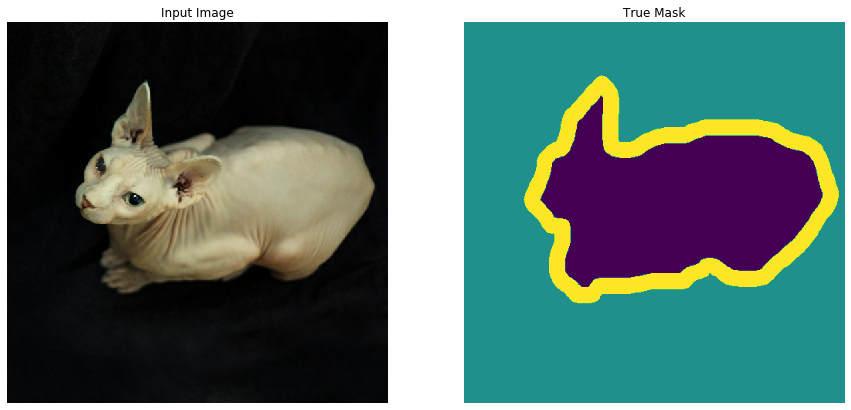

In [9]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

### Putting all together

Now that we have both sides of the U architecture, we can put all together and create the U-Net model

In [10]:
model = unet_model_2d(loss_function=soft_dice_loss, input_shape=(572,572,3), metrics=[dice_coefficient], depth=5,
                      n_labels=4, deconvolution=True)

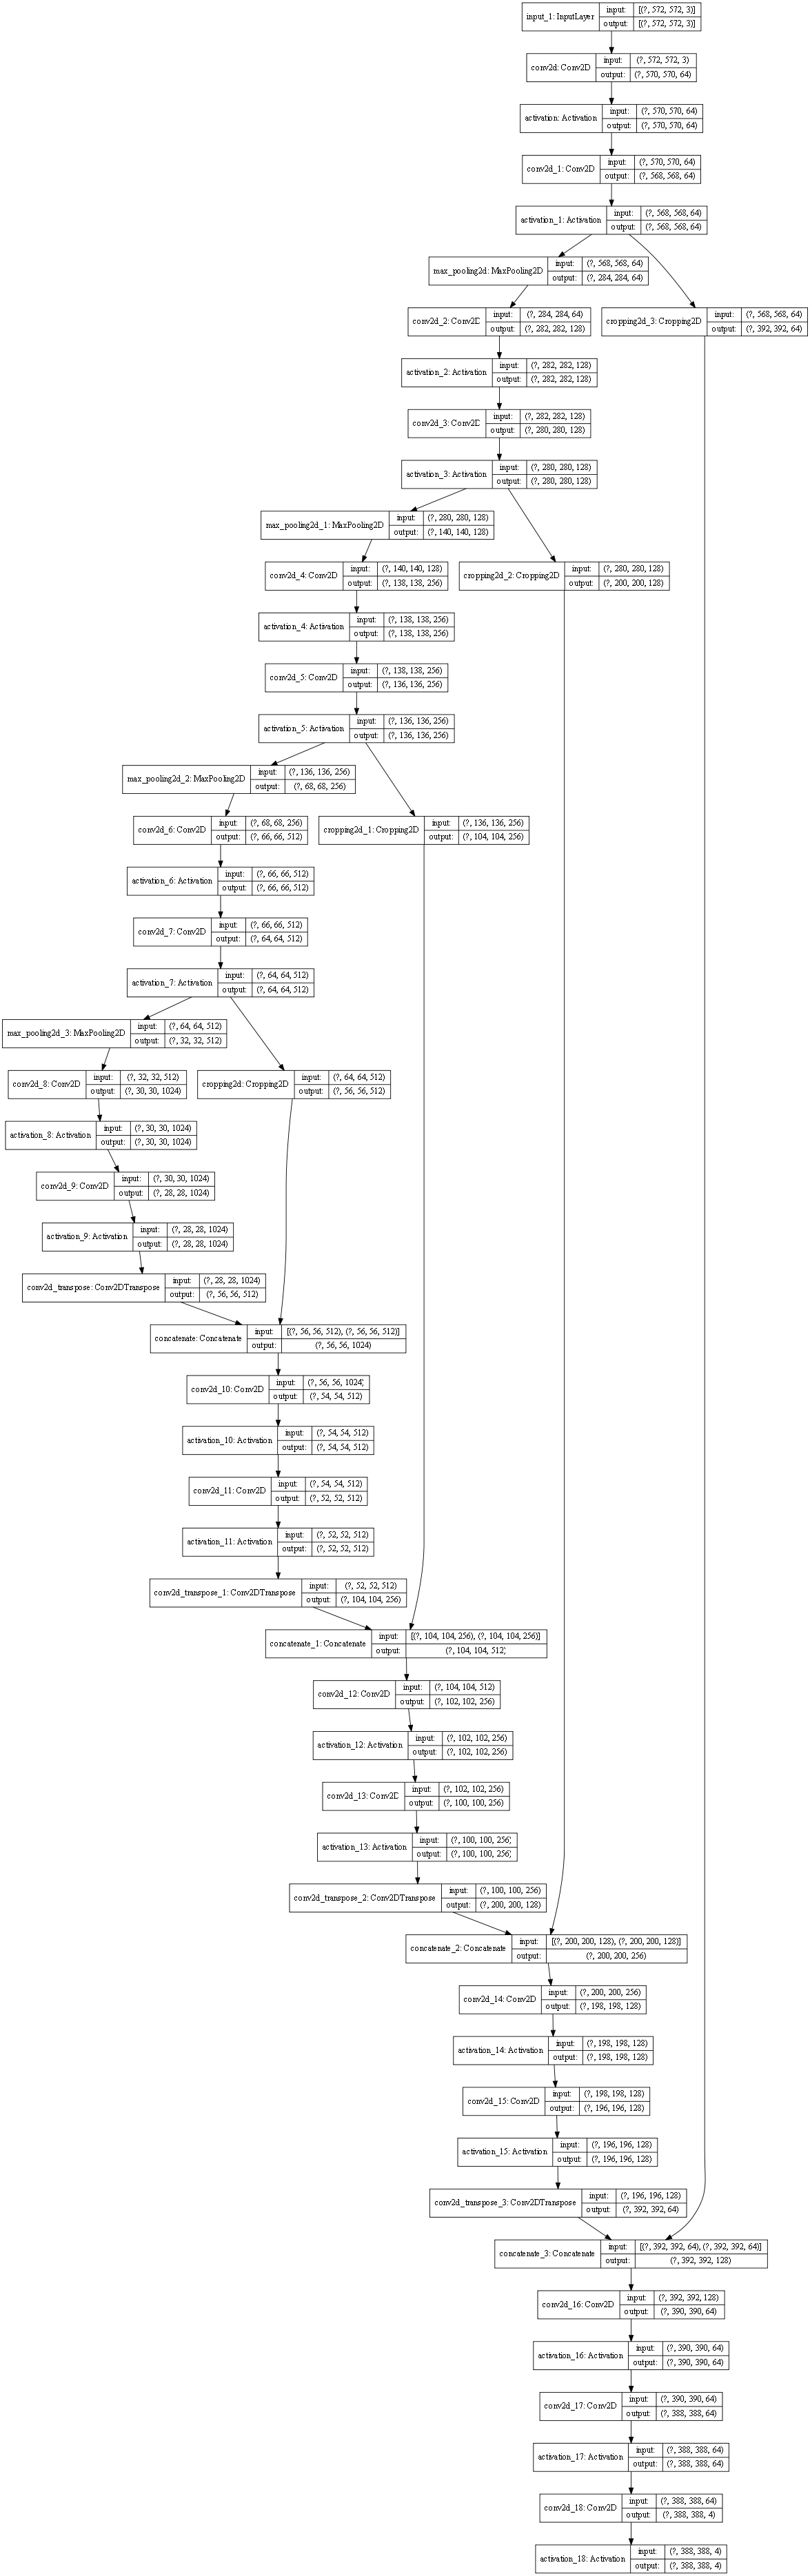

In [11]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [12]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [13]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

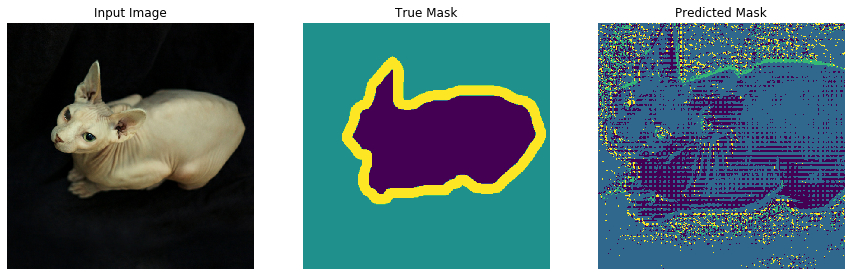

In [14]:
show_predictions()

Note how the prediction is too bad! Well, the model was not trained yet :-)

In [15]:
# Write model saving callback.
model_save_callback = tf.keras.callbacks.ModelCheckpoint(
    './model_checkpoint', monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=False, mode='auto', save_freq='epoch')

In [16]:
model_history = model.fit(train_dataset, epochs=EPOCHS, validation_data=test_dataset, callbacks=[model_save_callback])

    920/Unknown - 528s 574ms/step - loss: 0.3071 - dice_coefficient: 1.0932WARNING:tensorflow:From D:\dl_toolkits\miniconda3\envs\dl4m-gpu\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: ./model_checkpoint\assets


INFO:tensorflow:Assets written to: ./model_checkpoint\assets


920/920 [==============================] - 756s 822ms/step - loss: 0.3071 - dice_coefficient: 1.0932 - val_loss: 0.2832 - val_dice_coefficient: 1.1352


In [19]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

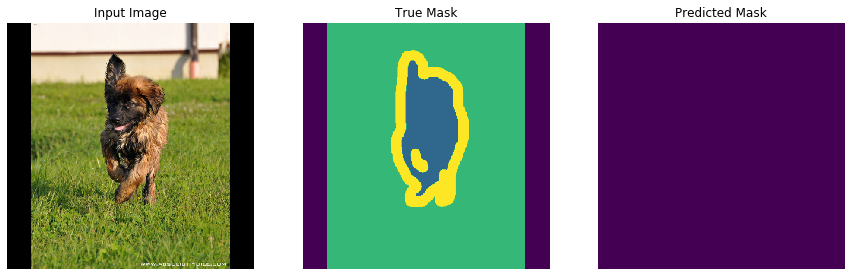

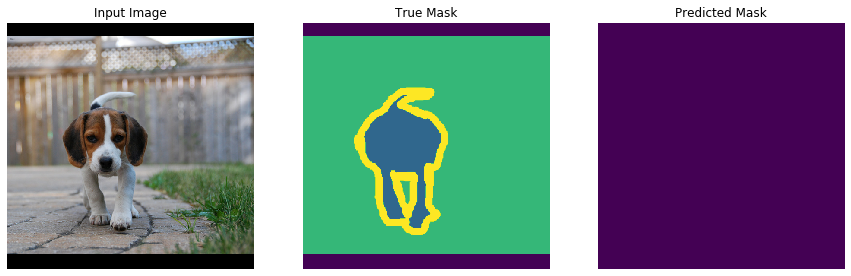

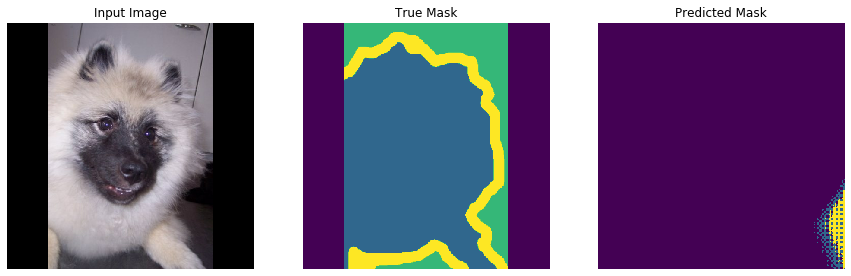

In [18]:
show_predictions(test_dataset, 3)